The goal of this notebook is to show how to compute the energy spectrum for the HF radar velocities.

In [136]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import griddata
from scipy import signal
import scipy.fftpack
from matplotlib import rcParams
%matplotlib inline
rcParams.update({'font.size': 20})

Select year and month of interest for the HF radar.

In [2]:
year, month = 2016, 4

# Input files

## HF radar

In [ ]:
The data are loaded through OPeNDAP from the thredds server. 

In [12]:
yyyy = str(year)
mm = str(month).zfill(2)
radarfile = ("http://thredds.socib.es/thredds/dodsC/hf_radar/"
            "hf_radar_ibiza-scb_codarssproc001/L1/{0}/"
            "dep0001_hf-radar-ibiza_scb-codarssproc001_L1_{1}-{2}.nc".format(yyyy, yyyy, mm))
print("Working on radar file: " +  radarfile)

Working on file: http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/2016/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_2016-04.nc


## Ibiza mooring

In [13]:
mooringfile = ("http://thredds.socib.es/thredds/dodsC/mooring/"
               "currentmeter/buoy_canaldeibiza-scb_dcs002/L1/{0}/"
               "dep0001_buoy-canaldeibiza_scb-dcs002_L1_{1}-{2}.nc".format(yyyy, yyyy, mm))
print("Working on Ibiza mooring file: " +  mooringfile)

Working on Ibiza mooring file: http://thredds.socib.es/thredds/dodsC/mooring/currentmeter/buoy_canaldeibiza-scb_dcs002/L1/2016/dep0001_buoy-canaldeibiza_scb-dcs002_L1_2016-04.nc


# Read the data

## Mooring

In [14]:
with netCDF4.Dataset(mooringfile) as nc:
    lon_mooring = nc.variables['LON'][:]
    lat_mooring = nc.variables['LAT'][:]
    vel = nc.variables['CUR_SPE'][:]
    direction = nc.variables['CUR_DIR'][:]
    time_mooring = nc.variables['time'][:]
    time_mooring_units = nc.variables['time'].units
u_mooring = vel * np.sin(np.deg2rad(direction))
v_mooring = vel * np.cos(np.deg2rad(direction))

Let's compute the inertial frequency:

In [113]:
f = 2 * 2 * (np.pi / 86400.) * np.sin(np.deg2rad(lat_mooring))
print f
T_intertial = 2 * np.pi / (3600 * f)
print(T_intertial)

9.11841920497e-05
19.1406998599


## HF radar

We will interpolate (linearly) the HF radar velocity field onto the position of the Ibiza Channel mooring.

In [29]:
with netCDF4.Dataset(radarfile) as nc:
    lon_radar = nc.variables['LON'][:]
    lat_radar = nc.variables['LAT'][:]
    u_radar = nc.variables['U'][:]
    v_radar = nc.variables['V'][:]
    time_radar = nc.variables['time'][:]
    time_radar_units = nc.variables['time'].units
    time_radar2plot = netCDF4.num2date(time_radar, time_radar_units)

Extract u and v from the radar at the mooring location:<br>
we can try interpolation using [interp2d](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html) function or consider the radar velocities as unstructured and use [griddata](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html), but the nan values located near to the mooring positions cause problems.

**Solution:** find the position of the nearest point.

In [16]:
llon_radar, llat_radar = np.meshgrid(lon_radar, lat_radar)
distance_matrix = np.sqrt((llon_radar - lon_mooring) ** 2  + (llat_radar - lat_mooring) ** 2)
i, j = np.unravel_index(distance_matrix.argmin(), distance_matrix.shape)
u_radar_interp = u_radar[:, i, j]
v_radar_interp = v_radar[:, i, j]

Just to check the position of the mooring and the radar closest grid point are as expected.

In [17]:
print(lon_mooring, lon_radar[j])
print(lat_mooring, lat_radar[i])

(array(0.783667), 0.77978000000000003)
(array(38.82445), 38.836500000000001)


## Test plot

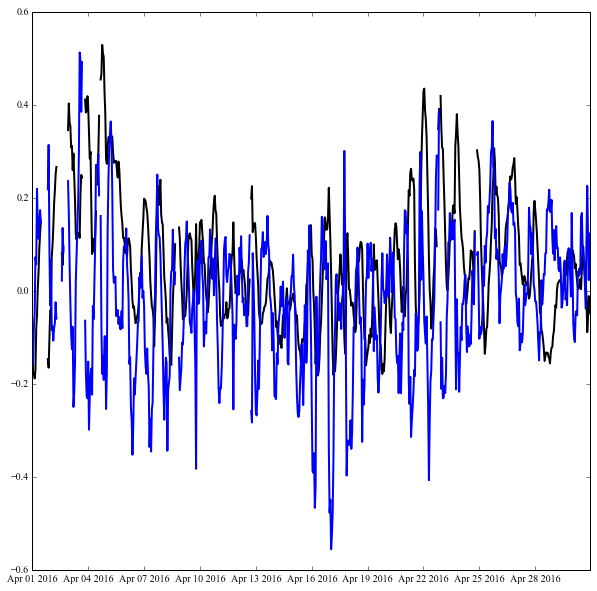

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.plot(time_radar2plot, u_radar_interp)
plt.plot(time_radar2plot, v_radar_interp)
plt.show()

# Fill in gaps

There are missing values and we need to fill them before performing Fourier analysis.<br>
Easiest solution: linear interpolation, considering that the gaps are not too large.

In [33]:
def linear_fill(x, y):
    """
    Fill the gap in a time serie using linear interpolation
    """
    good_values = np.where(~np.isnan(y))
    missing_values = np.where(np.isnan(y))
    y_interp = np.copy(y)
    y_interp[missing_values] = np.interp(x[missing_values], 
                                         x[good_values],
                                         y[good_values])
    return y_interp

In [34]:
u_radar_interp_filled = linear_fill(time_radar, u_radar_interp)
v_radar_interp_filled = linear_fill(time_radar, v_radar_interp)

## Test plot

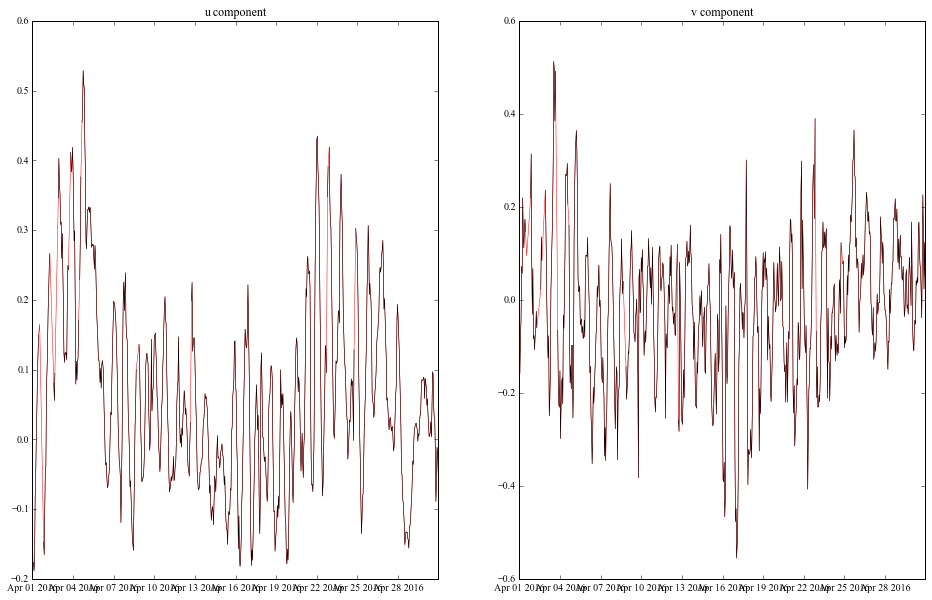

In [36]:
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(121)
ax.set_title('u component')
ax.plot(time_radar2plot, u_radar_interp_filled, 'r', lw=0.5)
ax.plot(time_radar2plot, u_radar_interp, lw=0.5)

ax = plt.subplot(122)
ax.set_title('v component')
ax.plot(time_radar2plot, v_radar_interp_filled, 'r', lw=0.5)
ax.plot(time_radar2plot, v_radar_interp, lw=0.5)
plt.show()

# Energy spectrum

## Numpy fft

We try first by using the fft module of numpy.

In [70]:
sampling_period = time_radar[2] - time_radar[1]
print("Sampling period = {0} {1}".format(sampling_period, time_radar_units))
N = len(u_radar_interp_filled)
print(N)

Sampling period = 3600.0 seconds since 1970-01-01 00:00:00
720


In [83]:
power_u = 20 * np.log10(np.abs(np.fft.rfft(u_radar_interp_filled)))
power_v = 20 * np.log10(np.abs(np.fft.rfft(v_radar_interp_filled)))
frq = np.linspace(0, 0.5 / sampling_period, N/2. + 1)
frq_max_u = frq[np.argmax(power_u)]

Compute position of the highest peaks for u and v components.<br>
We remove the first peaks (low frequency).

In [115]:
Npeaks = 10
ind_max_u = np.argpartition(power_u, -Npeaks)[-Npeaks:]
print(1. / (3600. * frq[ind_max_u[ind_max_u > 10]]))
ind_max_v = np.argpartition(power_v, -Npeaks)[-Npeaks:]
print(1. / (3600. * frq[ind_max_v[ind_max_v > 10]]))

[ 18.94736842  21.81818182  24.        ]
[ 18.46153846  24.          18.94736842  19.45945946  20.          20.57142857
  21.17647059  18.        ]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


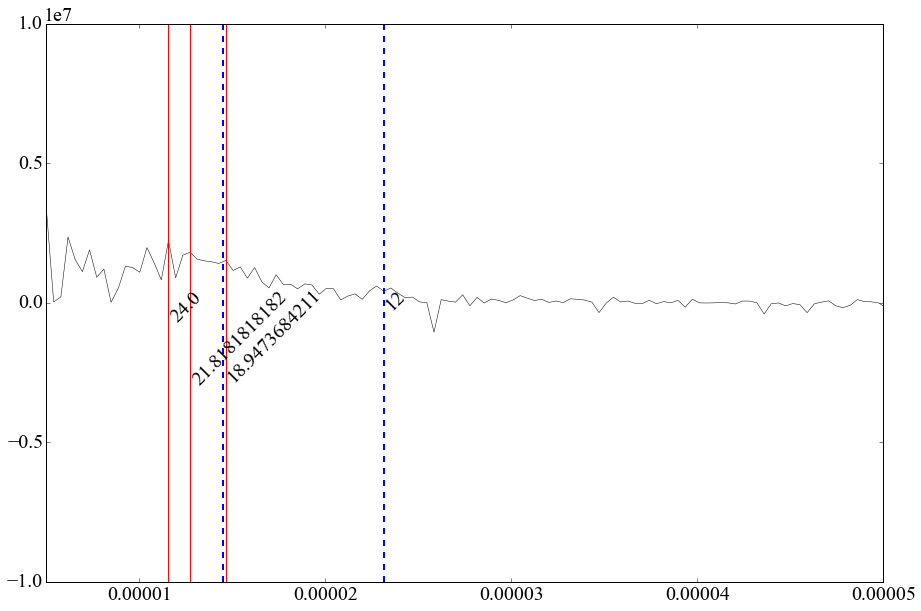

In [150]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
plt.plot(frq, power_u/frq, 'k-', lw=0.5)
for ind in ind_max_u[ind_max_u>10]:
    plt.axvline(x=frq[ind], ymin=0.0, ymax = 40, linewidth=1, color='r')
    plt.text(frq[ind], 41, str(1. / frq[ind] / 3600.), rotation=45)
plt.axvline(x=1 / (12. * 3600), ymin=0.0, ymax = 40, linewidth=2, color='b', linestyle='--')
plt.text(1 / (12. * 3600), 41, str(12), rotation=45)
plt.axvline(x=1 / (T_intertial * 3600), ymin=0.0, ymax = 40, linewidth=2, color='b', linestyle='--')
#plt.text(1 / (T_intertial * 3600), 43, str(T_intertial), rotation=45)

ax.set_xlim(5e-6, 5e-5)
ax.set_ylim(-1e7, 1e7)
plt.show()

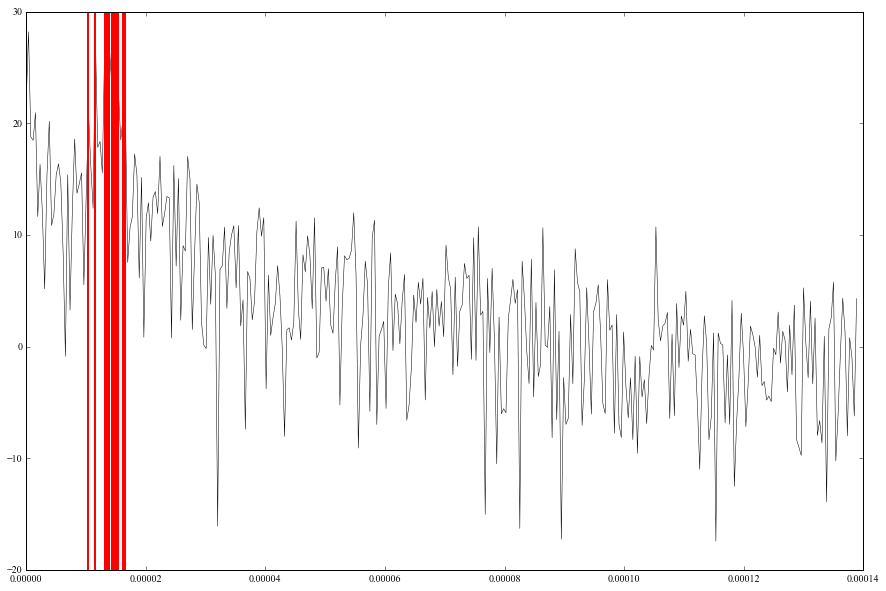

In [109]:
fig = plt.figure(figsize=(15, 10))
plt.plot(frq, power_v, 'k-', lw=0.5)
for ind in ind_max_v[ind_max_v>10]:
    plt.axvline(x=frq[ind], ymin=0.0, ymax = 40, linewidth=2, color='r')
plt.show()

## scipy fftpack

In [52]:
power_u2 = 20 * np.log10(np.abs(scipy.fftpack.fft(u_radar_interp_filled)))
power_v2 = 20 * np.log10(np.abs(scipy.fftpack.fft(v_radar_interp_filled)))

In [66]:
power_u2.shape

(720,)

## sciypy signal

In [45]:
f, Sk_u = signal.periodogram(u_radar_interp_filled, return_onesided = True, scaling = "spectrum")
f, Sk_v = signal.periodogram(v_radar_interp_filled, return_onesided = True, scaling = "spectrum")

## Rotary energy spectrum

Taken from https://github.com/pyoceans/python-oceans/blob/master/oceans/ff_tools/ocfis.py

In [46]:
def spec_rot(u, v):
    """
    Compute the rotary spectra from u,v velocity components
    Parameters
    ----------
    u : array_like
    zonal wind velocity [m s :sup:`-1`]
    v : array_like
    meridional wind velocity [m s :sup:`-1`]
    Returns
    -------
    cw : array_like
    Clockwise spectrum [TODO]
    ccw : array_like
    Counter-clockwise spectrum [TODO]
    puv : array_like
    Cross spectra [TODO]
    quv : array_like
    Quadrature spectra [ TODO]
    Notes
    -----
    The spectral energy at some frequency can be decomposed into two circularly
    polarized constituents, one rotating clockwise and other anti-clockwise.
    Examples
    --------
    TODO: puv, quv, cw, ccw = spec_rot(u, v)
    References
    ----------
    .. [1] J. Gonella Deep Sea Res., 833-846, 1972.
    """
    # Individual components Fourier series.
    fu, fv = list(map(np.fft.fft, (u, v)))
    # Auto-spectra of the scalar components.
    pu = fu * np.conj(fu)
    pv = fv * np.conj(fv)
    # Cross spectra.
    puv = fu.real * fv.real + fu.imag * fv.imag
    # Quadrature spectra.
    quv = -fu.real * fv.imag + fv.real * fu.imag
    # Rotatory components
    # TODO: Check the division, 4 or 8?
    cw = (pu + pv - 2 * quv) / 4.
    ccw = (pu + pv + 2 * quv) / 4.
    N = len(u)
    F = np.arange(0, N) / N
    return puv, quv, cw, ccw, F

In [47]:
puv, quv, cw, ccw, F = spec_rot(u_radar_interp_filled, v_radar_interp_filled)

# Plots

Let's identify the frequency (and period) of the 5 highest peaks.<br>
We can do it with [argpartition](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argpartition.html).

In [73]:
Npeaks = 5
ind_max = np.argpartition(power_v, -Npeaks)[-Npeaks:]
period_max = 1 / (frq[ind_max] * 3600.)
print("Maximal period in hours: {0}".format(period_max))

Maximal period in hours: [  17.14285714   24.           20.          720.                   inf]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


## Periodogram

We did not apply any log, hence the difference (no negative values etc).

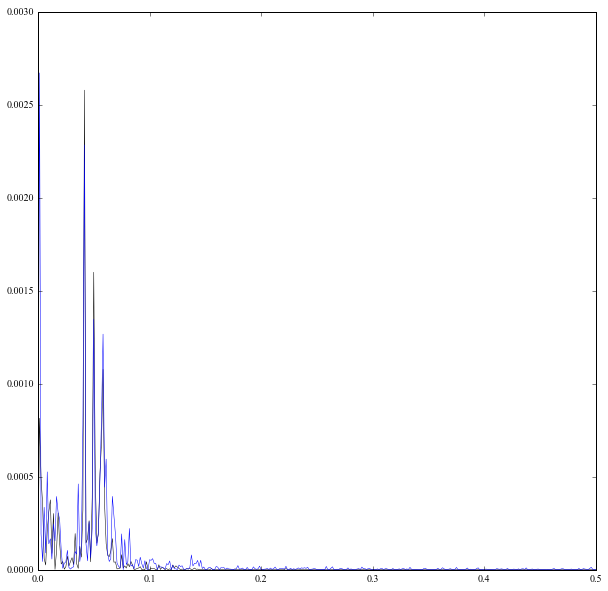

In [76]:
fig = plt.figure(figsize=(10, 10))
plt.plot(f, Sk_u, 'k-', lw=0.5)
plt.plot(f, Sk_v, 'b-', lw=0.5)
plt.show()

In [78]:
Npeaks = 5
ind_max = np.argpartition(Sk_v, -Npeaks)[-Npeaks:]
period_max = 1 / (f[ind_max] * 3600.)
print("Maximal period in hours: {0}".format(period_max))

Maximal period in hours: [ 0.00487805  0.00555556  0.2         0.00666667  0.0047619 ]


## Rotary spectrum 

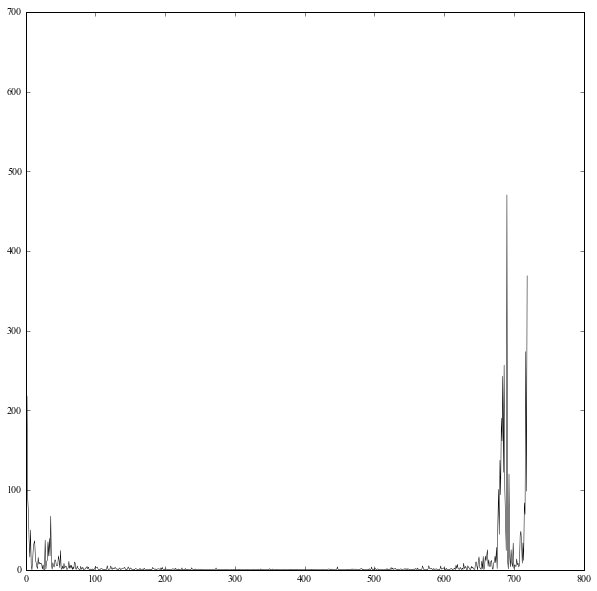

In [143]:
fig = plt.figure(figsize=(10, 10))
plt.plot(ccw, lw=0.5)
plt.show()

# Tests...

Check if the filled time series is ok

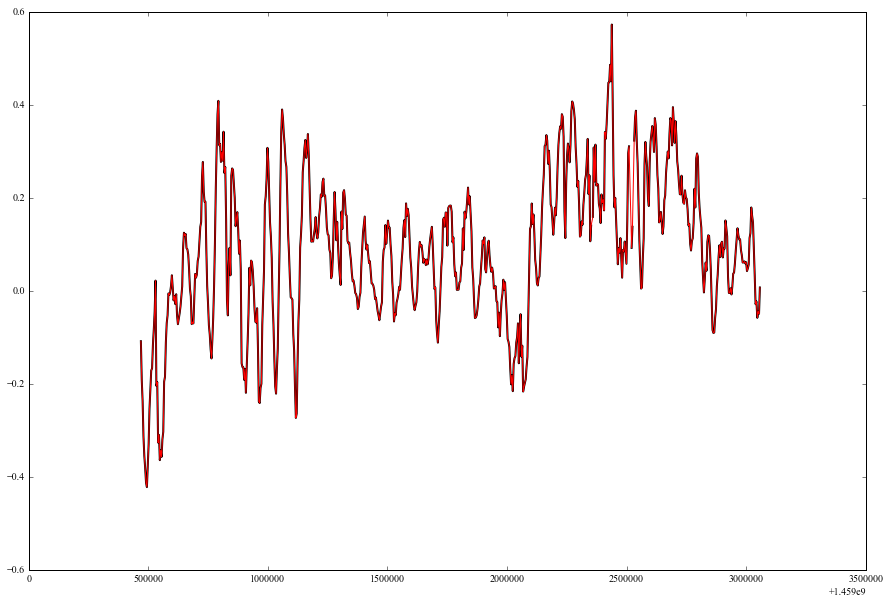

In [67]:
u2plot_interp = linear_fill(time, u2plot)

fig = plt.figure(figsize=(15, 10))
plt.plot(time, u2plot, 'k', lw=2)
plt.plot(time, u2plot_interp, 'r-', lw=1)
plt.show()

Check the mooring position

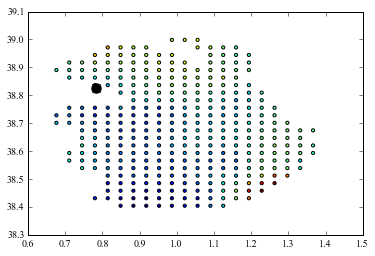

In [97]:
plt.scatter(llon_radar, llat_radar, c=u_radar[0, :, :], s=10)
plt.plot(lon_mooring, lat_mooring, 'ko', ms=10)
plt.show()